In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import keras_tuner as kt
from scipy import sparse

from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load tags and convert to binary matrix
tags = pd.read_csv('../data/vectorized_data/tags.csv')
tags['tags'] = tags['tags'].apply(ast.literal_eval)
scraped_tags = ['real-analysis','calculus','linear-algebra','probability','abstract-algebra','integration',
                'sequences-and-series','combinatorics','general-topology','matrices','functional-analysis',
                'complex-analysis','geometry','group-theory','algebra-precalculus','probability-theory',
                'ordinary-differential-equations','limits','analysis','number-theory','measure-theory',
                'statistics','multivariable-calculus','functions','derivatives','differential-geometry',
                'discrete-mathematics','trigonometry','algebraic-geometry','elementary-set-theory']
tags['tags'] = tags['tags'].apply(lambda x: [tag for tag in x if tag in scraped_tags])
mlb = MultiLabelBinarizer()
tags_binary = mlb.fit_transform(tags['tags'])

In [3]:
# Load vectorized data
files = os.listdir('../data/vectorized_data/sparse_matrices')
data = {}
for file in files:
    if file.endswith('.npz'):
        data[file] = sparse.load_npz(os.path.join('../data/vectorized_data/sparse_matrices', file)) 

In [4]:
# Initial train and test split
X_train_full, X_test, y_train_full, y_test = train_test_split(np.arange(len(tags_binary)), tags_binary, test_size=0.2, random_state=42)

# Further split the training data into training and cross-validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Output shapes to verify the splits
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (141186,), (141186, 30)
Validation set: (47063,), (47063, 30)
Test set: (47063,), (47063, 30)


## Find Best Model

In [5]:
# Function to create neural network
def create_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,), sparse=True),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(y_train.shape[1], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [66]:
# Train and evaluate model for each type of vectorized data
results = {}
for filename, X in data.items():
    X_train_vec = X[X_train]
    X_val_vec = X[X_val]

    model = create_model(X_train_vec.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    model.fit(X_train_vec, y_train, epochs=50, batch_size=32, validation_data=(X_val_vec, y_val), callbacks=[early_stopping])
    
    y_pred = (model.predict(X_val_vec) > 0.5).astype(int)

    metrics = {
        'hamming_loss': hamming_loss(y_val, y_pred),
        'f1_micro': f1_score(y_val, y_pred, average='micro'),
        'f1_macro': f1_score(y_val, y_pred, average='macro'),
        'precision': precision_score(y_val, y_pred, average='micro'),
        'recall': recall_score(y_val, y_pred, average='micro'),
        'subset_accuracy': accuracy_score(y_val, y_pred)
    }
    
    results[filename] = metrics

# Print results
for filename, metrics in results.items():
    print(f'\n{filename}:')
    for metric_name, metric_value in metrics.items():
        print(f'  {metric_name}: {metric_value:.4f}')

Epoch 1/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.3282 - loss: 0.1514 - val_accuracy: 0.4893 - val_loss: 0.0979
Epoch 2/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.4812 - loss: 0.1034 - val_accuracy: 0.4922 - val_loss: 0.0950
Epoch 3/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.4933 - loss: 0.0987 - val_accuracy: 0.4953 - val_loss: 0.0937
Epoch 4/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.5031 - loss: 0.0955 - val_accuracy: 0.4970 - val_loss: 0.0931
Epoch 5/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.5075 - loss: 0.0937 - val_accuracy: 0.4995 - val_loss: 0.0928
Epoch 6/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5152 - loss: 0.0918 - val_accuracy: 0.5076 - val_loss: 0.0925
Epoch 7/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5202 - loss: 0.0898 - val_accuracy: 0.5039 - val_loss: 0.0926
Epoch 8/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5240 - loss: 0

In [6]:
file_map = {
    'raw_1000.npz':'Raw, 1000',
    'raw_2000.npz':'Raw, 2000',
    'raw_5000.npz':'Raw, 5000',
    'raw_10000.npz':'Raw, 10000',
    'raw_15000.npz':'Raw, 15000',
    'text_latex_coarse_1000.npz':'Separated Coarse, 1000',
    'text_latex_coarse_2000.npz':'Separated Coarse, 2000',
    'text_latex_coarse_5000.npz':'Separated Coarse, 5000',
    'text_latex_coarse_10000.npz':'Separated Coarse, 10000',
    'text_latex_coarse_15000.npz':'Separated Coarse, 15000',
    'text_latex_fine_1000.npz':'Separated Fine, 1000',
    'text_latex_fine_2000.npz':'Separated Fine, 2000',
    'text_latex_fine_5000.npz':'Separated Fine, 5000',
    'text_latex_fine_10000.npz':'Separated Fine, 10000',
    'text_latex_fine_15000.npz':'Separated Fine, 15000',
    'text_latex_raw_1000.npz':'Separated Raw, 1000',
    'text_latex_raw_2000.npz':'Separated Raw, 2000',
    'text_latex_raw_5000.npz':'Separated Raw, 5000',
    'text_latex_raw_10000.npz':'Separated Raw, 10000',
    'text_latex_raw_15000.npz':'Separated Raw, 15000',
}

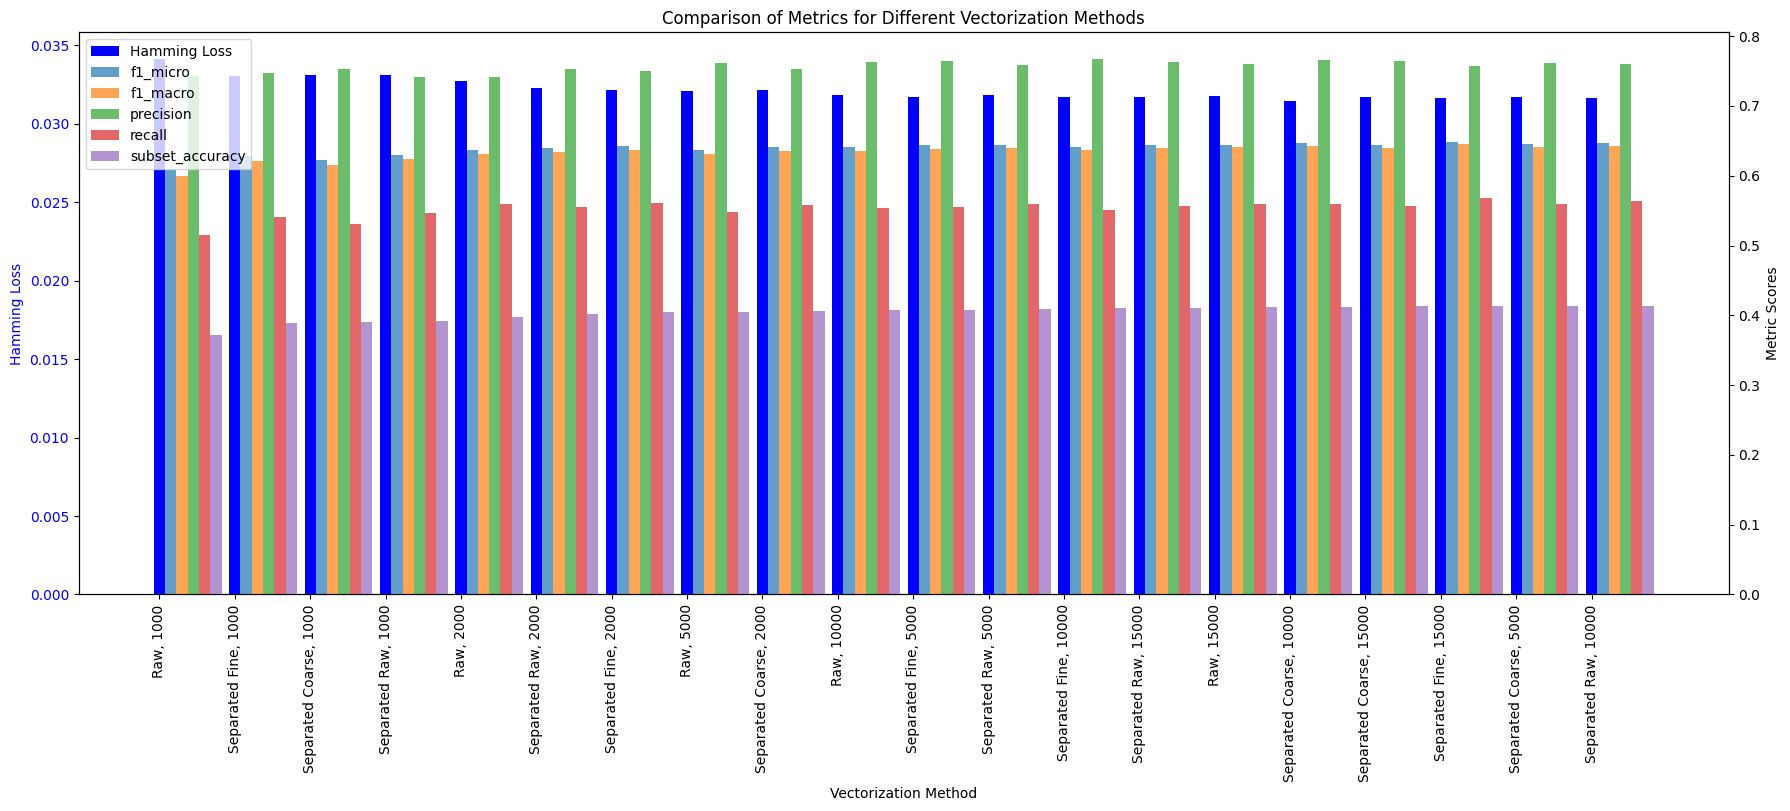

In [4]:
# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results).T.sort_values(by='subset_accuracy')

# Reset index for better plotting
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Vectorization Method'}, inplace=True)

# Rename filenames to better index names
results_df['Vectorization Method'] = results_df['Vectorization Method'].map(file_map)

# Metrics to be plotted
metrics = ['f1_micro', 'f1_macro', 'precision', 'recall', 'subset_accuracy']

# Number of bars and bar width
n_bars = len(results_df)
bar_width = 0.15
index = np.arange(n_bars)

# Create subplots
fig, ax1 = plt.subplots(figsize=(18, 8))

# Plot Hamming Loss
hamming_bar = ax1.bar(index, results_df['hamming_loss'], bar_width, label='Hamming Loss', color='b')
ax1.set_xlabel('Vectorization Method')
ax1.set_ylabel('Hamming Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(index)
ax1.set_xticklabels(results_df['Vectorization Method'], rotation=90)

# Secondary axis for other metrics
ax2 = ax1.twinx()
for i, metric in enumerate(metrics):
    ax2.bar(index + (i + 1) * bar_width, results_df[metric], bar_width, label=metric, alpha=0.7)

ax2.set_ylabel('Metric Scores', color='k')
ax2.tick_params(axis='y', labelcolor='k')

# Add legend
fig.tight_layout()
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# Set the title of the plot
plt.title('Comparison of Metrics for Different Vectorization Methods')

# Show the plot
plt.savefig('../figs/nn_models/vectorization_comparison.png', bbox_inches='tight')
plt.show()

## Train One Specific Model

In [5]:
# Load one of the datasets for demonstration purposes
X_train_vec = data['text_latex_coarse_5000.npz'][X_train]
X_val_vec = data['text_latex_coarse_5000.npz'][X_val]

In [6]:
# Function to create a neural network with hyperparameters
def model_builder(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), activation='relu', input_dim=X_train_vec.shape[1]))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Initialize Keras Tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='hyperparam_tuning')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(X_train_vec, y_train, epochs=10, validation_data=(X_val_vec, y_val), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal hyperparameters
print(f"The optimal number of units in the first layer is: {best_hps.get('units1')}")
print(f"The optimal dropout rate in the first layer is: {best_hps.get('dropout1')}")
print(f"The optimal number of units in the second layer is: {best_hps.get('units2')}")
print(f"The optimal dropout rate in the second layer is: {best_hps.get('dropout2')}")

Trial 77 Complete [00h 15m 05s]
val_accuracy: 0.5351337790489197

Best val_accuracy So Far: 0.5436542630195618
Total elapsed time: 18h 17m 53s

Search: Running Trial #78

Value             |Best Value So Far |Hyperparameter
224               |512               |units1
0.2               |0.5               |dropout1
160               |320               |units2
0.2               |0.3               |dropout2
17                |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/17
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 55s 13ms/step - accuracy: 0.6286 - loss: 0.0584 - val_accuracy: 0.5203 - val_loss: 0.0947
Epoch 6/17
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 117s 26ms/step - accuracy: 0.5484 - loss: 0.0846 - val_accuracy: 0.5402 - val_loss: 0.0850
Epoch 3/17
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 118s 26ms/step - accuracy: 0.5916 - loss: 0.0707 - val_accuracy: 0.5366 -

In [9]:
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the final model
history = model.fit(X_train_vec, y_train, epochs=50, batch_size=32, validation_data=(X_val_vec, y_val))

# Evaluate the model on the test set
X_test_vec = data['text_latex_coarse_5000.npz'][X_test]
y_test_pred = (model.predict(X_test_vec) > 0.5).astype(int)

metrics = {
        'hamming_loss': hamming_loss(y_test, y_test_pred),
        'f1_micro': f1_score(y_test, y_test_pred, average='micro'),
        'f1_macro': f1_score(y_test, y_test_pred, average='macro'),
        'precision': precision_score(y_test, y_test_pred, average='micro'),
        'recall': recall_score(y_test, y_test_pred, average='micro'),
        'subset_accuracy': accuracy_score(y_test, y_test_pred)
    }

Epoch 1/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 102s 23ms/step - accuracy: 0.3966 - loss: 0.1349 - val_accuracy: 0.5390 - val_loss: 0.0861
Epoch 2/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 100s 23ms/step - accuracy: 0.5527 - loss: 0.0830 - val_accuracy: 0.5313 - val_loss: 0.0852
Epoch 3/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 100s 23ms/step - accuracy: 0.5783 - loss: 0.0747 - val_accuracy: 0.5458 - val_loss: 0.0859
Epoch 4/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 102s 23ms/step - accuracy: 0.5999 - loss: 0.0681 - val_accuracy: 0.5419 - val_loss: 0.0875
Epoch 5/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 102s 23ms/step - accuracy: 0.6191 - loss: 0.0626 - val_accuracy: 0.5287 - val_loss: 0.0904
Epoch 6/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 102s 23ms/step - accuracy: 0.6340 - loss: 0.0576 - val_accuracy: 0.5356 - val_loss: 0.0933
Epoch 7/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 102s 23ms/step - accuracy: 0.6447 - loss: 0.0537 - val_accuracy: 0.5323 - val_loss: 0.0974
Epoch 8/50
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 102s 23ms/step - accuracy: 

In [10]:
metrics

{'hamming_loss': 0.037216072073603466,
 'f1_micro': 0.6350712217075153,
 'f1_macro': 0.64391734397057,
 'precision': 0.6404129256369672,
 'recall': 0.6298178912857811,
 'subset_accuracy': 0.3745617576440091}

In [17]:
y_test_pred[3]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])